<a href="https://colab.research.google.com/github/DmitrijMakarov/cosmo_luch/blob/main/luch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Импорт необходимых библиотек###

In [1]:
!pip3 install catboost
import catboost as cat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
import keras
from tensorflow import keras
from keras import layers

In [3]:
import seaborn as sns

###Считывание данных###

In [4]:
def read_binarry(file_path):
    import struct
    import math

    power = []
    age = []
    coordinate_x = []
    coordinate_y = []
    angle_tetta = []
    angle_phi = []
    energy = []
    time = []

    with open(file_path, 'rb') as binary_file:
        for i in range(100000):
            binary_file.read(4 * 5)

            tetta = struct.unpack('f', binary_file.read(4))[0]
            angle_tetta.append(tetta)

            phi = struct.unpack('f', binary_file.read(4))[0]
            angle_phi.append(phi)

            x0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_x.append(x0)

            y0 = struct.unpack('f', binary_file.read(4))[0]
            coordinate_y.append(y0)

            binary_file.read(4 * 5)

            power_eas = struct.unpack('f', binary_file.read(4))[0]
            power.append(math.log10(power_eas))

            age_eas = struct.unpack('f', binary_file.read(4))[0]
            age.append(age_eas)

            binary_file.read(4 * 1565)
            energy_release = struct.unpack('f' * 36, binary_file.read(4 * 36))
            energy.append(energy_release)

            binary_file.read(4)
            t = struct.unpack('f' * 144, binary_file.read(4 * 144))
            threshold_time = t[::4]
            time.append(threshold_time)


    # Собираем всё в DataFrame
    df = pd.DataFrame({
        'power': power,
        'age': age,
        'x': coordinate_x,
        'y': coordinate_y,
        'tetta': angle_tetta,
        'phi': angle_phi,
        'energy': energy,
        'threshold_time': time,
    })

    y_data = pd.DataFrame({
        'power': power,
        'age': age,
        'x': coordinate_x,
        'y': coordinate_y,
        'tetta': angle_tetta,
        'phi': angle_phi,})

    return df, y_data

df, y_data = read_binarry('spe27p_100k_2022_correct.dat')

In [4]:
df

,power,age,x,y,tetta,phi,energy,threshold_time
0,4.166507,1.444716,13.572407,37.022316,37.367474,47.313324,"(0.10191129148006439, 11.324358940124512, 13.0...","(-1.0, 91830.7265625, 91844.828125, 91830.7109..."
1,4.933104,1.430547,40.330677,-61.980999,28.912228,236.400421,"(10.563158988952637, 0.0, 7.604449272155762, 1...","(61243.13671875, -1.0, 61215.59375, 61216.8359..."
2,4.133581,1.459046,-1.046695,-63.925430,37.267426,182.086060,"(0.0, 0.34477588534355164, 0.35262614488601685...","(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, 78681.062..."
3,5.190620,1.326983,40.293152,-21.836197,3.205503,201.268890,"(34.960296630859375, 40.36423873901367, 6.7627...","(52147.2421875, 52211.25, 52142.87890625, 5213..."
4,5.021614,1.336776,15.542248,10.037846,6.299241,108.097626,"(79.6240234375, 29.508312225341797, 60.4609146...","(88044.953125, 88053.078125, 88046.9453125, 88..."
...,...,...,...,...,...,...,...,...
99995,4.503942,1.295468,36.338993,32.139332,44.537529,31.058533,"(8.940515518188477, 0.0, 0.0, 1.29427850246429...","(96596.9765625, -1.0, -1.0, -1.0, 96563.203125..."
99996,5.301322,1.302831,-29.983866,-38.277843,16.121550,158.978851,"(103.17373657226562, 123.92174530029297, 360.8...","(74179.7890625, 74196.1640625, 74172.7578125, ..."
99997,3.617597,1.473757,18.329506,-13.626085,46.820038,13.862854,"(0.0, 0.23389649391174316, 0.0, 1.705774307250...","(-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...."
99998,4.017301,1.510002,-36.200687,-53.555149,33.087467,157.593292,"(0.0, 0.0, 8.356832504272461, 16.7534923553466...","(-1.0, -1.0, 166325.0, 166352.15625, -1.0, -1...."


In [5]:
X_data = pd.DataFrame({})

for i in range(36):
    _energy = []
    for j in range(len(df["energy"])):
        _energy.append(df['energy'][j][i])
    X_data[f'energy{i}'] = _energy
for i in range(36):
    _time = []
    for j in range(len(df["threshold_time"])):
        _time.append(df['threshold_time'][j][i])
    X_data[f'time{i}'] = _time

In [6]:
X = X_data.copy()

###Предсказывание значений оси x###

In [7]:
y_x = df['x']
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X, y_x, test_size=0.2)

In [8]:
gb_x = GradientBoostingRegressor()
gb_x.fit(X_train_x, y_train_x)

GradientBoostingRegressor()

In [9]:
y_pred_x = gb_x.predict(X_test_x)

In [10]:
r2_score(y_pred_x, y_test_x)

0.6935787412071224

In [11]:
y_pred_x

array([11.28697575, 13.7668584 , 19.99480333, ...,  0.87541496,
       13.43650588, 25.71007239])

###Предсказывание значений оси y###

In [12]:
y_y = df['y']
X_train_y, X_test_y, y_train_y, y_test_y = train_test_split(X, y_y, test_size=0.2)

In [13]:
gb_y = GradientBoostingRegressor()
gb_y.fit(X_train_y, y_train_y)

GradientBoostingRegressor()

In [14]:
y_pred_y = gb_y.predict(X_test_y)

In [15]:
r2_score(y_pred_y, y_test_y)

0.8553134635240778

In [16]:
y_pred_y

array([ 50.23797587,  -4.73877281,  44.13383761, ...,  50.63808093,
       -14.38251872, -18.73979705])

###Предсказание углов###

In [16]:
y_angles = df[['tetta', 'phi']]

In [17]:
y_angles

,tetta,phi
0,37.367474,47.313324
1,28.912228,236.400421
2,37.267426,182.086060
3,3.205503,201.268890
4,6.299241,108.097626
...,...,...
99995,44.537529,31.058533
99996,16.121550,158.978851
99997,46.820038,13.862854
99998,33.087467,157.593292


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_angles, random_state=1234, test_size=0.2)
# angles
model_angles = keras.Sequential(
    [
        layers.Dense(72, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(300, activation='relu'),
        layers.Dense(2, activation='softplus'),
    ]
)

model_angles.compile(
    optimizer='AdamW',
    loss='categorical_crossentropy',
    metrics=["accuracy"],
    )

history = model_angles.fit(
    X_train,
    Y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.1
)

Exception ignored in: <function _xla_gc_callback at 0x784fca3484a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8744 - loss: 98.2255 - val_accuracy: 0.9124 - val_loss: 90.5123
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9080 - loss: 90.6623 - val_accuracy: 0.9124 - val_loss: 90.3511
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9085 - loss: 90.6469 - val_accuracy: 0.9124 - val_loss: 90.3278
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.9082 - loss: 90.6750 - val_accuracy: 0.9124 - val_loss: 90.3091
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9077 - loss: 90.5475 - val_accuracy: 0.9124 - val_loss: 90.3421


In [19]:
# Оценка модели на тестовых данных
results = model_angles.evaluate(X_test, Y_test, batch_size=128, verbose=1)

# Вывод результатов
print(f"Test accuracy: {results[1]:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9095 - loss: 90.7011
Test accuracy: 0.9089


In [24]:
def diff_x(x_y_test):
  X_data = pd.DataFrame({})

  for i in range(36):
      _energy = []
      for el in x_y_test['energy'].keys():
          _energy.append(x_y_test['energy'][el][i])
      X_data[f'energy{i}'] = _energy
  for i in range(36):
      _time = []
      for el in x_y_test['threshold_time'].keys():
          _time.append(x_y_test['threshold_time'][el][i])
      X_data[f'time{i}'] = _time

  return X_data

def diff_y(x_y_test):
  return pd.DataFrame({
      'tetta': x_y_test['tetta'],
      'phi': x_y_test['phi'],
  })

In [25]:
boot_accuracies = []

for i in range(20):
    x_y_test_boot = df.sample(n=25000)
    y_test_boot = diff_y(x_y_test_boot)
    X_test_boot = diff_x(x_y_test_boot)

    results = model_angles.evaluate(X_test_boot, y_test_boot, batch_size=128, verbose=1)
    boot_accuracies.append(results[1])

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9113 - loss: 90.1914
196/196 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9102 - loss: 90.4925
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9072 - loss: 90.3211
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9086 - loss: 90.7526
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9125 - loss: 90.5325
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9085 - loss: 90.5162
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9050 - loss: 90.2470
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9072 - loss: 90.5899
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9079 - loss: 90.2726
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9099 - loss: 90.3957
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9121 - loss: 90.7360
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9078 - loss: 90.6409
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9069 - loss: 90.3562
196/196 ━━━

<Axes: ylabel='Count'>

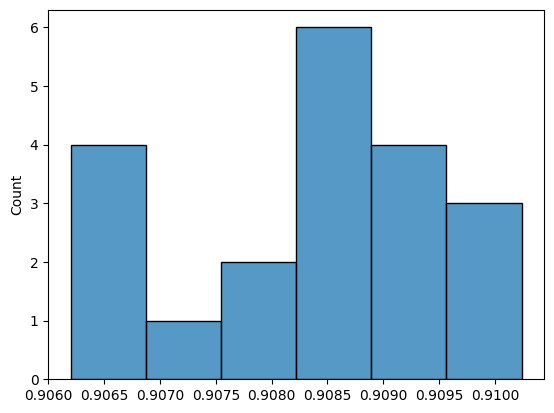

In [26]:
sns.histplot(boot_accuracies)

###Предсказание мошности и возраста ливня###

In [20]:
y_power_age = df[['power', 'age']]

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X_data, y_power_age, random_state=1234, test_size=0.2)
# power and age
model_power_age = keras.Sequential(
    [
        layers.Dense(72, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(2, activation='softplus'),
    ]
)

model_power_age.compile(
    optimizer='AdamW',
    loss='categorical_crossentropy',
    metrics=["accuracy"],
    )

history = model_power_age.fit(
    X_train,
    Y_train,
    batch_size=128,
    epochs=10,
    validation_split=0.1
)

Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9917 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 1.0000 - val_loss: nan
Epoch 9/10
563/563 ━━━━

In [22]:
# Оценка модели на тестовых данных
results = model_power_age.evaluate(X_test, Y_test, batch_size=128, verbose=1)

# Вывод результатов
print(f"Test accuracy: {results[1]:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: nan
Test accuracy: 1.0000


In [27]:
def diff_x(x_y_test):
  X_data = pd.DataFrame({})

  for i in range(36):
      _energy = []
      for el in x_y_test['energy'].keys():
          _energy.append(x_y_test['energy'][el][i])
      X_data[f'energy{i}'] = _energy
  for i in range(36):
      _time = []
      for el in x_y_test['threshold_time'].keys():
          _time.append(x_y_test['threshold_time'][el][i])
      X_data[f'time{i}'] = _time

  return X_data

def diff_y(x_y_test):
  return pd.DataFrame({
      'power': x_y_test['power'],
      'age': x_y_test['age'],
  })


In [28]:
boot_accuracies = []

for i in range(20):
    x_y_test_boot = df.sample(n=25000)
    y_test_boot = diff_y(x_y_test_boot)
    X_test_boot = diff_x(x_y_test_boot)

    results = model_power_age.evaluate(X_test_boot, y_test_boot, batch_size=128, verbose=1)
    boot_accuracies.append(results[1])

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: nan
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - lo

<Axes: ylabel='Count'>

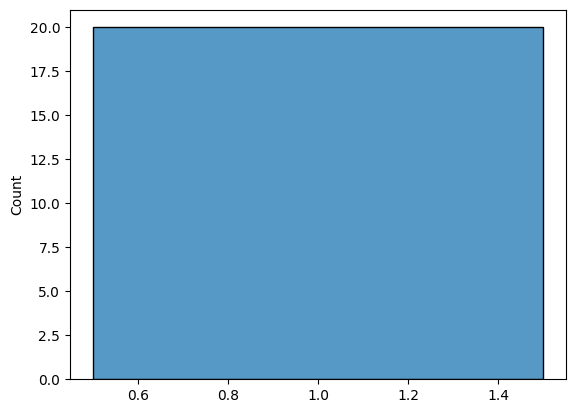

In [29]:
sns.histplot(boot_accuracies)